<a href="https://colab.research.google.com/github/belalabouzaid/siads699_team13_collab/blob/main/Notebooks/03b-Train_Test_Models_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Objective
The aim of this notebook is to train/test several simple machine learning regression models in order to select the most useful prediction algorithm for the drought prediction problem. This will be run Three Rivers and Mariposa training datasets.

# Testing and comparing regression models

In [ ]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# To work with numpy arrays
import numpy as np
# ML model building, training and testing
import sklearn
# Liner regression model building
from sklearn.linear_model import LinearRegression
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
# sklearn included transformer
from sklearn.preprocessing import QuantileTransformer
# to split data into test and train
from sklearn.model_selection import train_test_split
# Scaling transform for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# To run PCA feature reduction
from sklearn.decomposition import PCA
# XGBoost model
from xgboost import XGBRegressor,XGBClassifier
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
# for regression error calculation
from sklearn.metrics import mean_absolute_error
# for regression r2 score calculation
from sklearn.metrics import r2_score
# for regression mse score calculation
from sklearn.metrics import mean_squared_error
# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# To transform the target variable into a normal distribution
from sklearn.compose import TransformedTargetRegressor

In [ ]:
# Defining a function to train and test models
def train_test_model(df, reg, features, scale = False, test_size= 0.25, n_pca = None):
  # takes as an input df: dataframe with all independent variables and the output variable. Output variable must be the last column.
  #                   reg: model constructor, example: reg = LinearRegression()
  #                   features: series of features from the dataset to be used for train/test, compute this using X.columns
  #                   scale = Option to scale features prior to training, default = False
  #                   test_size = float, percentage of data to be used for testing. Default = 0.25 (25%)
  #                   n_pca = int, number of principal components to reduce the independent varibles to. Default = None (no pca is done). Recommended to use scale = True if using pca.
  print(type(reg).__name__)

  X = df.iloc[:,:-1] # Select all independent variables as X
  y = df.iloc[:,-1]  # Select the last variable in the dataframe as the target variable y

  # Splitting the data into test (25%) and train (75%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)

  # Normalize independent variables (both train and test) if required
  if scale == True:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

  # Run PCA if required. Recommended to normalize if PCA will be used
  if n_pca is not None:
    pca = PCA(n_components= n_pca)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

  # Features into a dataframe
  X_train_df= pd.DataFrame(X_train)
  # Come back to this lower line, should get columns from input variable feature as a list
  #X_train_df.columns=X.columns
  #X_train_df.columns= features
  X_test_df= pd.DataFrame(X_test)
  #X_test_df.columns=X.columns
  #X_test_df.columns= features

  #reg.fit(X_train_df[features],y_train)
  reg.fit(X_train_df,y_train)
  #y_pred_reg = reg.predict(X_test_df[features])
  y_pred_reg = reg.predict(X_test_df)

  results = {}
  r2 = r2_score(y_test, y_pred_reg)
  n = len(y_test)
  k = len(features)
  adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))
  mae = mean_absolute_error(y_test,y_pred_reg)
  mse = mean_squared_error(y_test,y_pred_reg)

  print("Features used for model training = ", features)
  print("Number of principal components used for model training = ", n_pca)
  print("MAE = ", mae)
  print("MSE = ", mse)
  print("R2 Score = ", r2 )
  print("Adjusted R2 Score = ", adj_r2_score)

  results['X_train'] = X_train
  results['y_train'] = y_train
  results['X_test'] = X_test
  results['y_test'] = y_test
  results['y_pred_reg'] = y_pred_reg
  results['MAE'] = mae
  results['MSE'] = mse
  results['R2 Score'] = r2
  results['Adjusted R2 Score'] = adj_r2_score
  results['name'] = type(reg).__name__

  return results

In [ ]:
# A function to gather prediction results generated by different models in a df
def results_to_df(reg_results):
  # takes an input reg_results: a list of the dictionaries holding the returned results of each regression
  results_df = pd.DataFrame()
  for dictt in reg_results:
    results_df[dictt['name']] = dictt['y_pred_reg']
  results_df['y_test'] = y_test.values
  return results_df

In [ ]:
# A function to test and compare model parameters
def stats_to_df(reg_results):
  # takes an input reg_results: a list of the dictionaries holding the returned results of each regression
  stats_df = pd.DataFrame()
  for dictt in reg_results:
    stats_df[dictt['name']] = [dictt['MAE'], dictt['MSE'], dictt['R2 Score'], dictt['Adjusted R2 Score']]
  stats_df = stats_df.set_axis(['MAE', 'MSE', 'R2 Score', 'Adjusted R2 Score'])
  return stats_df

## THREE RIVERS

In [ ]:
ThreeRivers22 = pd.read_csv('https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/threerivers_2022.csv')

In [ ]:
X = ThreeRivers22.drop(columns = 'smi')
y = ThreeRivers22['smi']

In [ ]:
features = ['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10','MSI','MNDWI','SR_B7','SR_B6','MSAVI']

In [ ]:
X = X[features]

In [ ]:
#Splitting the data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Simple linear regression model to be used as benchmark no parameters
lin_reg = LinearRegression()
lin_reg_results = train_test_model(ThreeRivers22, lin_reg, features = features, scale = True, test_size= 0.25, n_pca = None)

LinearRegression
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MSI', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.012514170585825756
MSE =  0.0003593821827668763
R2 Score =  0.8088248178092186
Adjusted R2 Score =  0.8085866731782795


In [ ]:
# Simple RF model
# max_depth = 3 takes 15 minutes
rf_reg = RandomForestRegressor(max_depth=12)
rf_reg_results = train_test_model(ThreeRivers22, rf_reg, features = features, scale = False, test_size= 0.25, n_pca = None)

RandomForestRegressor
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MSI', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.009309363577535264
MSE =  0.000202297334054275
R2 Score =  0.8923869029989654
Adjusted R2 Score =  0.8922528506550584


In [ ]:
# XGBoost Regression no parameters (alternative tree based algorithm)
# max_depth = 3 takes 14 sec to run
xgb_reg = XGBRegressor(max_depth=12)
xgb_reg_results = train_test_model(ThreeRivers22, xgb_reg, features = features, scale = False, test_size= 0.25, n_pca = None)

XGBRegressor
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MSI', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.008676915302130066
MSE =  0.00017577805763503918
R2 Score =  0.90649396713326
Adjusted R2 Score =  0.9063774877899036


In [ ]:
reg_results = [lin_reg_results, rf_reg_results, xgb_reg_results]
results_df = results_to_df(reg_results)
results_df

,LinearRegression,RandomForestRegressor,XGBRegressor,y_test
0,0.373860,0.264869,0.277439,0.154935
1,0.181027,0.171419,0.171985,0.174334
2,0.177551,0.180893,0.175829,0.177410
3,0.265187,0.264745,0.270234,0.254980
4,0.216886,0.210894,0.220516,0.209691
...,...,...,...,...
10445,0.292497,0.267151,0.266765,0.275420
10446,0.307744,0.295188,0.293347,0.292765
10447,0.255710,0.250360,0.238649,0.240955
10448,0.209642,0.225212,0.220408,0.212479


In [ ]:
reg_results = [lin_reg_results, rf_reg_results, xgb_reg_results]
stats_df = stats_to_df(reg_results)
stats_df

,LinearRegression,RandomForestRegressor,XGBRegressor
MAE,0.012514,0.009309,0.008677
MSE,0.000359,0.000202,0.000176
R2 Score,0.808825,0.892387,0.906494
Adjusted R2 Score,0.808587,0.892253,0.906377


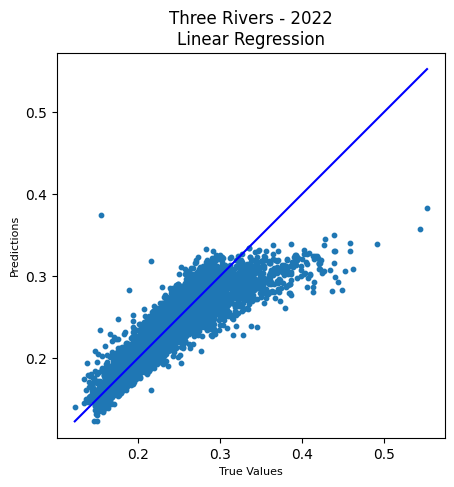

In [ ]:
# A function to plot different model results
plt.figure(figsize=(5,5))
plt.scatter(results_df['y_test'], results_df['LinearRegression']
            #, c='crimson'
            , s=10
            )
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(results_df['LinearRegression']), max(results_df['y_test']))
p2 = min(min(results_df['LinearRegression']), min(results_df['y_test']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.axis('equal')
plt.title("Three Rivers - 2022\nLinear Regression")
plt.show()

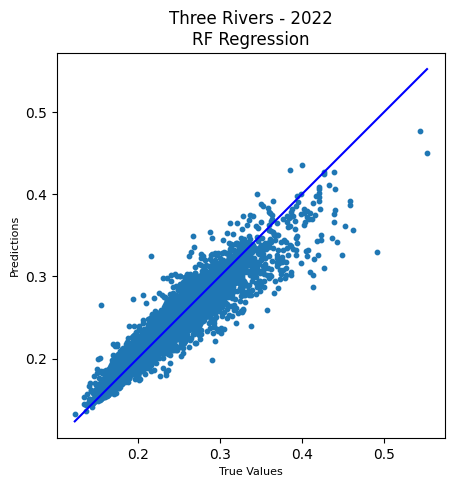

In [ ]:
# A function to plot different model results
plt.figure(figsize=(5,5))
plt.scatter(results_df['y_test'], results_df['RandomForestRegressor']
            #, c='crimson'
            , s=10
            )
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(results_df['RandomForestRegressor']), max(results_df['y_test']))
p2 = min(min(results_df['RandomForestRegressor']), min(results_df['y_test']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.axis('equal')
plt.title("Three Rivers - 2022\nRF Regression")
plt.show()

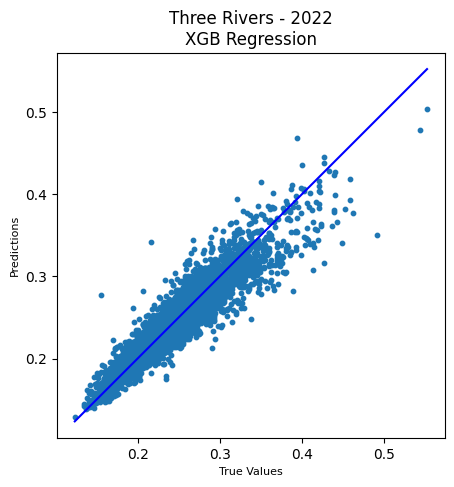

In [ ]:
# A function to plot different model results
plt.figure(figsize=(5,5))
plt.scatter(results_df['y_test'], results_df['XGBRegressor']
            #, c='crimson'
            , s=10
            )
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(results_df['XGBRegressor']), max(results_df['y_test']))
p2 = min(min(results_df['XGBRegressor']), min(results_df['y_test']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.axis('equal')
plt.title("Three Rivers - 2022\nXGB Regression")
plt.show()

## MARIPOSA

In [ ]:
Mariposa21 = pd.read_csv('https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/mariposa_2021.csv')

In [ ]:
X = Mariposa21.drop(columns = 'smi')
y = Mariposa21['smi']

In [ ]:
features = ['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10','MSI','MNDWI','SR_B7','SR_B6','MSAVI']

In [ ]:
X = X[features]

In [ ]:
#Splitting the data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Simple linear regression model to be used as benchmark no parameters
lin_reg = LinearRegression()
lin_reg_results = train_test_model(Mariposa21, lin_reg, features = features, scale = True, test_size= 0.25, n_pca = None)

LinearRegression
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MSI', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.044542978198295634
MSE =  0.00423995279707665
R2 Score =  0.7609070164464317
Adjusted R2 Score =  0.7607142234439384


In [ ]:
# Simple RF model
# max_depth = 3 takes 15 minutes
rf_reg = RandomForestRegressor(max_depth=12)
rf_reg_results = train_test_model(Mariposa21, rf_reg, features = features, scale = False, test_size= 0.25, n_pca = None)

RandomForestRegressor
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MSI', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.033077840362655875
MSE =  0.0021455875935990597
R2 Score =  0.8790092805790625
Adjusted R2 Score =  0.8789117195225886


In [ ]:
# XGBoost Regression no parameters (alternative tree based algorithm)
# max_depth = 3 takes 14 sec to run
xgb_reg = XGBRegressor(max_depth=12)
xgb_reg_results = train_test_model(Mariposa21, xgb_reg, features = features, scale = False, test_size= 0.25, n_pca = None)

XGBRegressor
Features used for model training =  ['aspect', 'slope', 'NDMI', 'SR_B5', 'SAVI', 'EVI', 'NDVI', 'ST_B10', 'MSI', 'MNDWI', 'SR_B7', 'SR_B6', 'MSAVI']
Number of principal components used for model training =  None
MAE =  0.03074998851132344
MSE =  0.0018969178880290207
R2 Score =  0.8930318852328504
Adjusted R2 Score =  0.8929456313256445


In [ ]:
reg_results = [lin_reg_results, rf_reg_results, xgb_reg_results]
results_df = results_to_df(reg_results)
results_df

,LinearRegression,RandomForestRegressor,XGBRegressor,y_test
0,0.269336,0.244552,0.252724,0.200931
1,0.296717,0.318289,0.359407,0.311420
2,0.360433,0.359278,0.372798,0.384078
3,0.364993,0.355746,0.352456,0.384158
4,0.319883,0.324549,0.321056,0.347181
...,...,...,...,...
16131,0.494975,0.509459,0.481778,0.230633
16132,0.256465,0.241735,0.223983,0.235942
16133,0.161190,0.167478,0.168799,0.178102
16134,0.141167,0.173255,0.165426,0.186466


In [ ]:
reg_results = [lin_reg_results, rf_reg_results, xgb_reg_results]
stats_df = stats_to_df(reg_results)
stats_df

,LinearRegression,RandomForestRegressor,XGBRegressor
MAE,0.044543,0.033078,0.030750
MSE,0.004240,0.002146,0.001897
R2 Score,0.760907,0.879009,0.893032
Adjusted R2 Score,0.760714,0.878912,0.892946


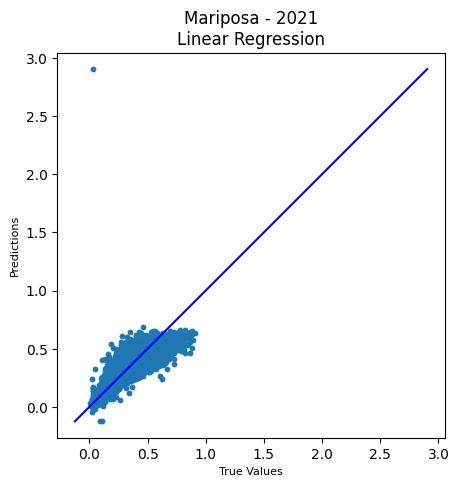

In [ ]:
# A function to plot different model results
plt.figure(figsize=(5,5))
plt.scatter(results_df['y_test'], results_df['LinearRegression']
            #, c='crimson'
            , s=10
            )
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(results_df['LinearRegression']), max(results_df['y_test']))
p2 = min(min(results_df['LinearRegression']), min(results_df['y_test']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.axis('equal')
plt.title("Mariposa - 2021\nLinear Regression")
plt.show()

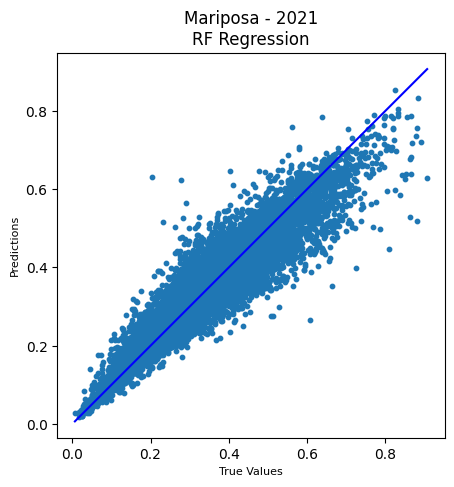

In [ ]:
# A function to plot different model results
plt.figure(figsize=(5,5))
plt.scatter(results_df['y_test'], results_df['RandomForestRegressor']
            #, c='crimson'
            , s=10
            )
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(results_df['RandomForestRegressor']), max(results_df['y_test']))
p2 = min(min(results_df['RandomForestRegressor']), min(results_df['y_test']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.axis('equal')
plt.title("Mariposa - 2021\nRF Regression")
plt.show()

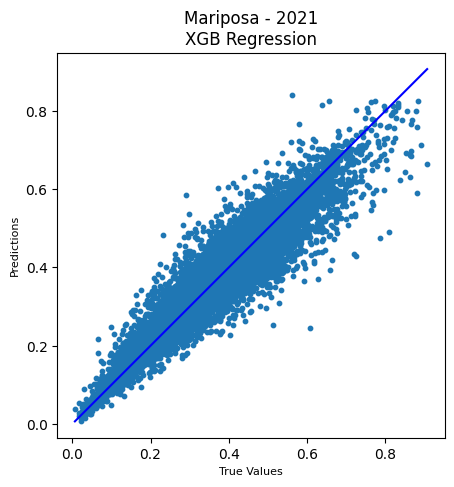

In [ ]:
# A function to plot different model results
plt.figure(figsize=(5,5))
plt.scatter(results_df['y_test'], results_df['XGBRegressor']
            #, c='crimson'
            , s=10
            )
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(results_df['XGBRegressor']), max(results_df['y_test']))
p2 = min(min(results_df['XGBRegressor']), min(results_df['y_test']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.axis('equal')
plt.title("Mariposa - 2021\nXGB Regression")
plt.show()

From the above regression results, the r2 scores and the plots show that the RF and XGB perform better than linear regression and subsequent prediction will focus on.